In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

import sys
sys.path.append('../..')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_plotting = os.path.join(folder_AGVA, 'Plotting')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi)

In [3]:
### create a smoothed ocean outline

# open ocean shapefile
path_ocean = os.path.join(folder_plotting, 'ne_10m_ocean', 'ne_10m_ocean.shp')
ocean = gpd.read_file(path_ocean)
ocean_orig = ocean.copy().to_crs("EPSG:3338")

# simplify ocean shapefile by filling holes
new_geom = []
for polygon in ocean.geometry.values[0].geoms:
    list_interiors = []
    for interior in polygon.interiors:
        if Polygon(interior).area > 5:
            list_interiors.append(interior)
    new_geom.append(Polygon(polygon.exterior.coords, holes=list_interiors))
ocean['geometry'] = [MultiPolygon(new_geom)]
ocean = ocean.to_crs("EPSG:3338")

# further simplify by buffer in then out
ocean_smooth = ocean.buffer(-20000).buffer(20000)

# get 300 km buffer
ocean_300 = ocean_smooth.buffer(300000)

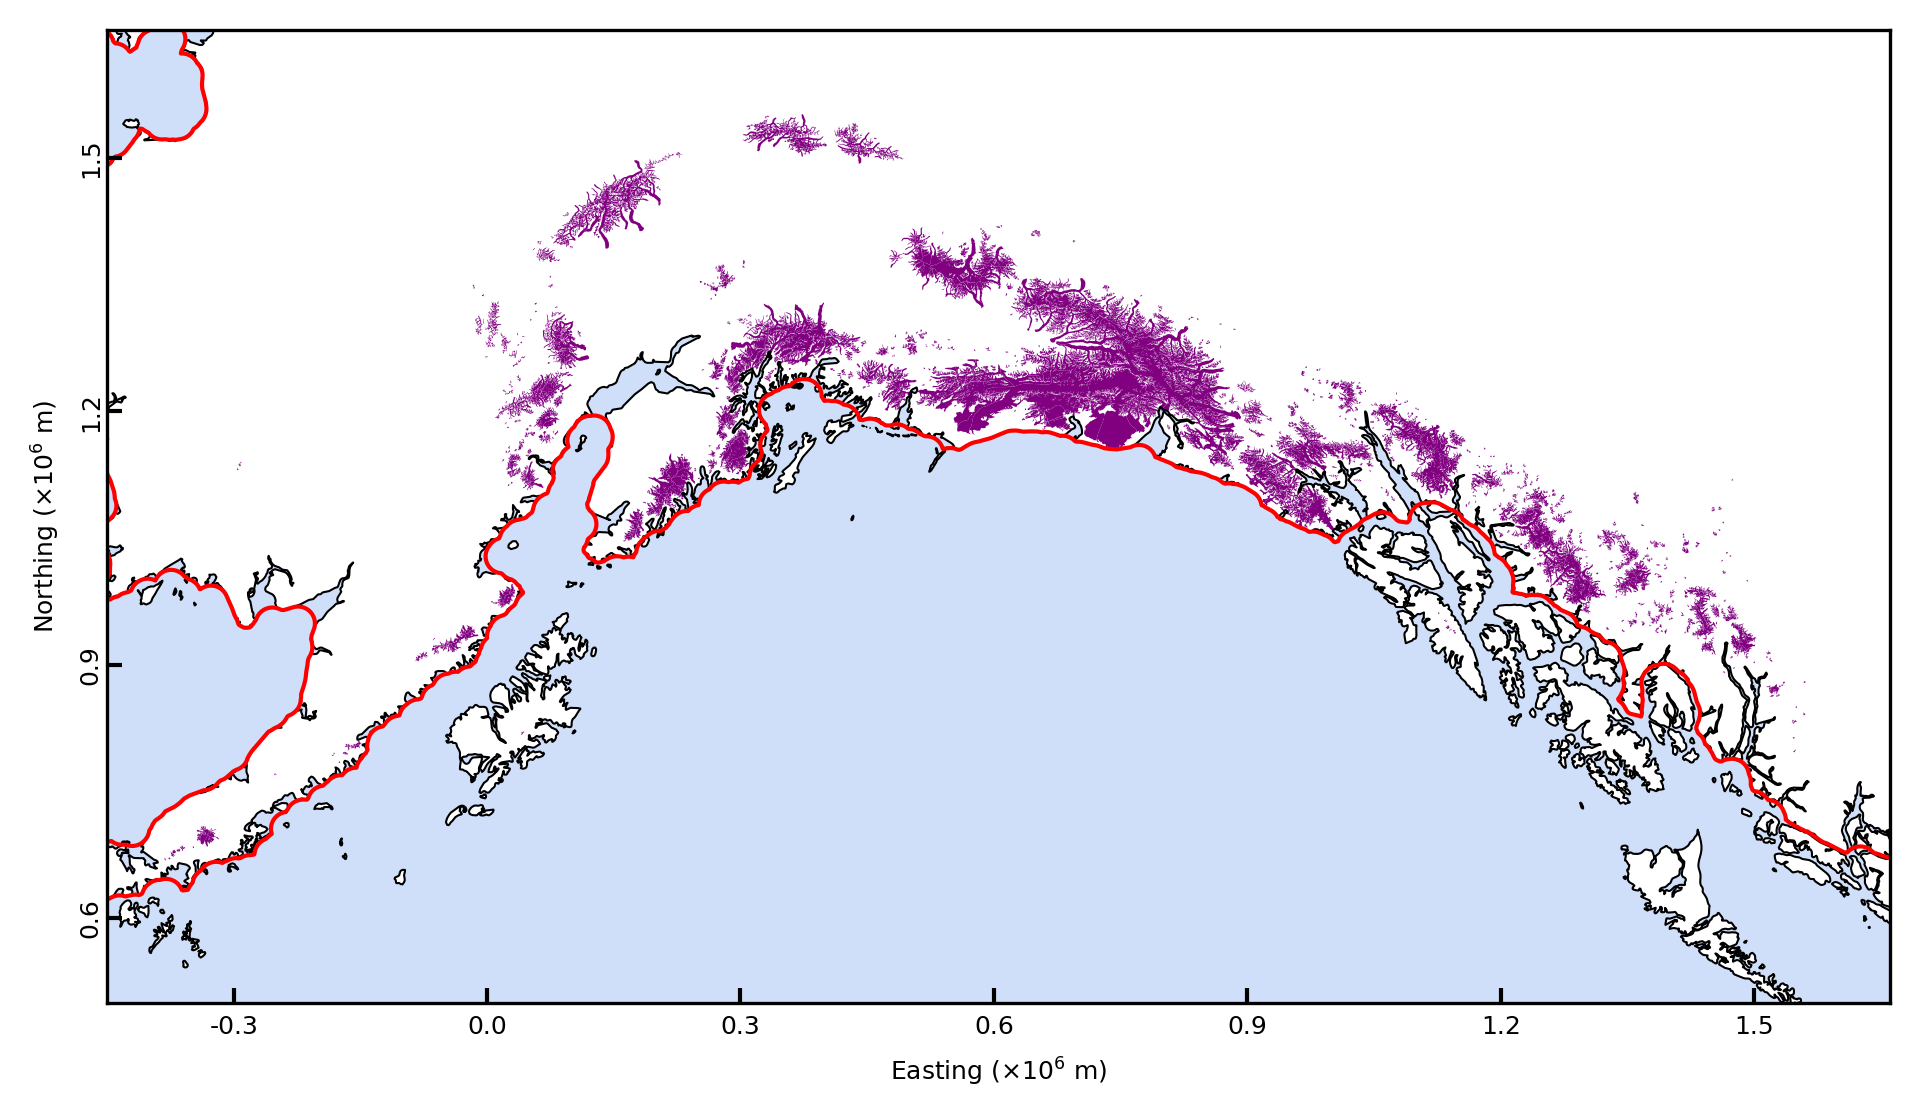

In [4]:
### Figure to show what this looks like
# ranges and ticks
xlims = (-450000, 1661000)
ylims = (500000, 1652000)
xticks = np.arange(-300000,1500001,300000)
yticks = np.arange(600000,1500001,300000)
xtick_labels = xticks/1000000
ytick_labels = yticks/1000000

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,5), dpi=300)

ocean_orig.plot(ax=axs, color='cornflowerblue', alpha=0.3, zorder=1.2)
ocean_orig.boundary.plot(ax=axs, color='black', linewidth=0.5, alpha=1, zorder=1.35)
ocean_smooth.boundary.plot(ax=axs, color='red', linewidth=1, alpha=1, zorder=1.35)
# ocean_smooth2.boundary.plot(ax=axs, color='yellow', linewidth=1, alpha=1, zorder=1.35)
rgi_gdf.plot(ax=axs, color='purple')

# set axis limits
axs.set_xlim(xlims)
axs.set_ylim(ylims)

# set axis ticks, format marks inwards
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xtick_labels)
axs.set_yticklabels(ytick_labels, rotation=90, va='center')
axs.tick_params(axis="x", pad=3, direction="in", width=1, labelsize=6, zorder=2)
axs.tick_params(axis="y" ,pad=1, direction="in", width=1, labelsize=6, zorder=2)

# set axis labels
axs.set_xlabel(r'Easting ($ \times 10^6$ m)', size=6)
axs.set_ylabel(r'Northing ($ \times 10^6$ m)', size=6)
plt.title("")

plt.tight_layout()

In [5]:
### calculate distance between glacier centroid and this product

# format to points
all_points = gpd.points_from_xy(rgi_gdf['CenLon'], rgi_gdf['CenLat'], z=None, crs="EPSG:4326").to_crs("EPSG:3338")

# to store info
all_rgis = []
all_distances = []

# loop through each point
for i, point in enumerate(all_points):
    
    # calculate distance to ocean
    dist = point.distance(ocean_smooth.geometry).values[0]/1000
    
    # if distance is 0, recalculate using the un-smoothed ocean boundary
    if dist==0:
        dist = point.distance(ocean_orig.geometry).values[0]/1000
        
    # append data
    all_distances.append(round(dist,2))
    all_rgis.append(rgi_gdf['RGIId'].values[i])
    
# format to df
distances_df = pd.DataFrame({"RGIId":all_rgis, "distance_from_ocean":all_distances})

# save
out_path = os.path.join(folder_AGVA, "Derived products", "S2", "distance_from_ocean.csv")
distances_df.to_csv(out_path, index=False)